## Imports

In [2]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import re
import numpy
from tqdm import tqdm

from math import cos,pi
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, confusion_matrix
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d
from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os
import rasterio
from glob import glob
import matplotlib.pyplot as plt
from rasterio.plot import show
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import math

import os
import numpy as np
import torch
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import random_split

from scipy.stats import mode


import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
BASE_PATH = '/kaggle/input/sentinel2-crop-mapping'
FOLDERS = ['lombardia', 'lombardia2']
YEARS = ['data2016', 'data2017', 'data2018']
IMG_SIZE = (48, 48)
BANDS = 9

def is_valid_image(file):
    return file.endswith('.tif') and '_MSAVI' not in file and os.path.basename(file) != 'y.tif'

def load_image_stack(tile_path):
    # Load and stack all satellite images (ignore MSAVI)
    img_files = sorted([f for f in os.listdir(tile_path) if is_valid_image(f)])
    stack = []
    for f in img_files:
        with rasterio.open(os.path.join(tile_path, f)) as src:
            arr = src.read()  # shape: (9, 48, 48)
            stack.append(arr)
    return np.stack(stack)  # shape: (T, 9, 48, 48)

def load_mask(tile_path):
    y_path = os.path.join(tile_path, 'y.tif')
    with rasterio.open(y_path) as src:
        mask = src.read(1)
    return remap_labels(mask, label_remap) #(48,48) image with remapped labels


In [4]:
label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

def remap_labels(mask, label_remap):
    return np.vectorize(lambda x: label_remap.get(x, 255))(mask).astype(np.uint8)


In [5]:
all_data = []

for region in FOLDERS:
    for year in YEARS:
        tiles_root = os.path.join(BASE_PATH, region, year)
        tile_ids = sorted(os.listdir(tiles_root))

        for tile_id in tqdm(tile_ids[:10], desc=f"{region}/{year}"):  # ← change [:10] to full load
            tile_path = os.path.join(tiles_root, tile_id)
            try:
                X = load_image_stack(tile_path)
                y = load_mask(tile_path)
                all_data.append((X, y))
            except Exception as e:
                print(f"❌ Failed to load {tile_path}: {e}")


lombardia2/data2018: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


In [6]:
label_counter = Counter()

for _, y in all_data:
    flat_labels = y.flatten()
    label_counter.update(flat_labels.tolist())

# Sort the label counts
label_counts = dict(sorted(label_counter.items()))

# ✅ Total number of unique labels
num_labels = len(label_counts)

# ✅ Total number of labeled pixels
total_pixels = sum(label_counts.values())

# 🔍 Print everything
print(f"🔢 Total unique labels: {num_labels}")
print(f"🧮 Total labeled pixels: {total_pixels}")
print("📊 Label Frequencies:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} pixels")

🔢 Total unique labels: 7
🧮 Total labeled pixels: 138240
📊 Label Frequencies:
  Label 0: 23334 pixels
  Label 1: 22003 pixels
  Label 2: 33120 pixels
  Label 3: 5191 pixels
  Label 4: 21574 pixels
  Label 5: 19636 pixels
  Label 6: 13382 pixels


In [7]:
#fixed seed
np.random.seed(13)

#80/20 split
total_len = len(all_data)
train_len = int(0.8 * total_len)
val_len = total_len - train_len
train_raw, val_raw = random_split(all_data, [train_len, val_len])

print(f"Total samples: {len(all_data)}")
print(f"Train samples: {len(train_raw)}")
print(f"Test samples:  {len(val_raw)}")

Total samples: 60
Train samples: 48
Test samples:  12


In [8]:
from collections import defaultdict

# Assume train_raw and/or val_raw is a list of (X, y) where X.shape = (T, 9, 48, 48)
# This works for any dataset (train_raw, val_raw, test_raw, etc.)
def analyze_timesteps(data):
    timestep_counts = defaultdict(int)

    for X, _ in data:
        T = X.shape[0]
        timestep_counts[T] += 1

    # Print detailed info
    print("📊 Unique Time Step Counts:")
    for T in sorted(timestep_counts):
        print(f"  T = {T}: {timestep_counts[T]} tiles")

    print(f"\n🧮 Total Unique T values: {len(timestep_counts)}")
    return timestep_counts

# Example usage
analyze_timesteps(train_raw)


📊 Unique Time Step Counts:
  T = 33: 8 tiles
  T = 34: 9 tiles
  T = 53: 15 tiles
  T = 68: 8 tiles
  T = 71: 8 tiles

🧮 Total Unique T values: 5


defaultdict(int, {53: 15, 68: 8, 71: 8, 33: 8, 34: 9})

Image sequence shape: (68, 9, 48, 48)
Ground truth shape: (48, 48)


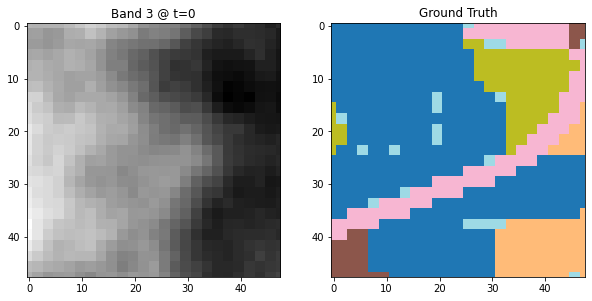

In [9]:
def plot_sample(X, y, timestep=0, band=3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(X[timestep, band], cmap='gray')
    axs[0].set_title(f'Band {band} @ t={timestep}')
    axs[1].imshow(y, cmap='tab20')
    axs[1].set_title('Ground Truth')
    plt.show()

# Plot a sample
sample_X, sample_y = all_data[20]
print(f"Image sequence shape: {sample_X.shape}")  # (T, 9, 48, 48)
print(f"Ground truth shape: {sample_y.shape}")    # (48, 48)
plot_sample(sample_X, sample_y, timestep=0, band=3)


# Model

In [10]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=9, out_channels=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):  # x: (B, 9, 48, 48)
        return self.net(x)  # (B, C, 48, 48)


In [16]:
class CNN_LSTM_Segmentation(nn.Module):
    def __init__(self, cnn_feat_dim=64, lstm_hidden=64, num_classes=7):
        super().__init__()
        self.cnn = CNNEncoder()
        self.lstm = nn.LSTM(input_size=cnn_feat_dim, hidden_size=lstm_hidden,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Conv2d(lstm_hidden*2, num_classes, kernel_size=1)

    def forward(self, x):  # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape

    # Extract spatial features from each image
        feat_seq = []
        for t in range(T):
            feat = self.cnn(x[:, t])  # (B, feat_dim, H, W)
            feat_seq.append(feat)
        feat_seq = torch.stack(feat_seq, dim=1)  # (B, T, feat_dim, H, W)

    # Prepare for LSTM
        feat_seq = feat_seq.permute(0, 3, 4, 1, 2)  # (B, H, W, T, feat_dim)
        feat_seq = feat_seq.reshape(B * H * W, T, -1)  # (B*H*W, T, feat_dim)

        lstm_out, _ = self.lstm(feat_seq)  # (B*H*W, T, 2H)
        lstm_last = lstm_out[:, -1, :]     # (B*H*W, 2H) seleetcing last timestep

        
        lstm_last = lstm_last.view(B, H, W, -1).permute(0, 3, 1, 2)  # (B, 128, H, W)
        out = self.classifier(lstm_last)   # (B, num_classes, H, W)
          # Conv2d: (B, num_classes, H, W)
        return out


In [12]:
class TileDataset(Dataset):
    def __init__(self, tile_data, window_size=25):
        self.data = tile_data
        self.window = window_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)


# Training

In [17]:

train_dataset = TileDataset(train_raw, window_size=25)
val_dataset = TileDataset(val_raw, window_size=25)

#train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

batch_size = 10

# List of all unique T values
time_steps = [33, 34, 53, 68, 71]

# Create train loaders for each T
train_loaders = []
for T in time_steps:
    subset = [d for d in train_raw if d[0].shape[0] == T]
    if subset:  # Only add loader if there's data for this T
        loader = DataLoader(TileDataset(subset), batch_size=batch_size, shuffle=True)
        train_loaders.append(loader)

# Create val loaders for each T
val_loaders = []
for T in time_steps:
    subset = [d for d in val_raw if d[0].shape[0] == T]
    if subset:
        loader = DataLoader(TileDataset(subset), batch_size=batch_size, shuffle=False)
        val_loaders.append(loader)



device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_LSTM_Segmentation().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Configurable
window_size = 10
stride = 4

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for train_loader in train_loaders:
        train_loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}", leave=False)
        for X_tile, y_tile in train_loop:
            X_tile = X_tile.to(device)  # (B, T, 9, 48, 48)
            y_tile = y_tile.to(device)  # (B, 48, 48)
            B, T, C, H, W = X_tile.shape

            logits_accum = []

            # Sliding windows
            for i in range(0, T - window_size + 1, stride):
                window = X_tile[:, i:i+window_size]  # (B, W, 9, 48, 48)
                out = model(window)  # (B, num_classes, 48, 48)
                logits_accum.append(out)  # (B, num_classes, 48, 48)

            if not logits_accum:
                continue  # skip batch if no valid windows

            # Average logits over all windows
            avg_logits = torch.stack(logits_accum, dim=0).mean(0)  # (B, num_classes, 48, 48)

            # Compute loss
            loss = criterion(avg_logits, y_tile)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = avg_logits.argmax(1)  # (B, 48, 48)
            correct += (pred == y_tile).sum().item()
            total += y_tile.numel()

            train_loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    train_loss = running_loss / sum(len(dl) for dl in train_loaders)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ===== Validation =====
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    for val_loader in val_loaders:
        val_loop = tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False)
        with torch.no_grad():
            for X_tile, y_tile in val_loop:
                X_tile = X_tile.to(device)
                y_tile = y_tile.to(device)
                B, T, C, H, W = X_tile.shape

                logits_accum = []

                for i in range(0, T - window_size + 1, stride):
                    window = X_tile[:, i:i+window_size]
                    out = model(window)
                    logits_accum.append(out)

                if not logits_accum:
                    continue

                avg_logits = torch.stack(logits_accum, dim=0).mean(0)  # (B, num_classes, 48, 48)
                loss = criterion(avg_logits, y_tile)
                val_loss += loss.item()

                pred = avg_logits.argmax(1)  # (B, 48, 48)
                correct += (pred == y_tile).sum().item()
                total += y_tile.numel()

    val_loss /= sum(len(dl) for dl in val_loaders)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}] ✅ "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/10] ✅ Train Loss: 1.9199, Train Acc: 0.1511, Val Loss: 1.8483, Val Acc: 0.2906


Epoch [2/10] ✅ Train Loss: 1.8820, Train Acc: 0.2258, Val Loss: 1.8029, Val Acc: 0.2911


Epoch [3/10] ✅ Train Loss: 1.8547, Train Acc: 0.2250, Val Loss: 1.7872, Val Acc: 0.3207


Epoch [4/10] ✅ Train Loss: 1.8199, Train Acc: 0.2284, Val Loss: 1.7766, Val Acc: 0.3035


Epoch [5/10] ✅ Train Loss: 1.8071, Train Acc: 0.2565, Val Loss: 1.7793, Val Acc: 0.3944


Epoch [6/10] ✅ Train Loss: 1.7799, Train Acc: 0.2615, Val Loss: 1.7768, Val Acc: 0.3652


Epoch [7/10] ✅ Train Loss: 1.7746, Train Acc: 0.2547, Val Loss: 1.7642, Val Acc: 0.3564


Epoch [8/10] ✅ Train Loss: 1.7690, Train Acc: 0.2526, Val Loss: 1.7598, Val Acc: 0.3998


Epoch [9/10] ✅ Train Loss: 1.7718, Train Acc: 0.2779, Val Loss: 1.7392, Val Acc: 0.4388


Epoch [10/10] ✅ Train Loss: 1.7610, Train Acc: 0.2852, Val Loss: 1.7270, Val Acc: 0.4394


# Evalutaion

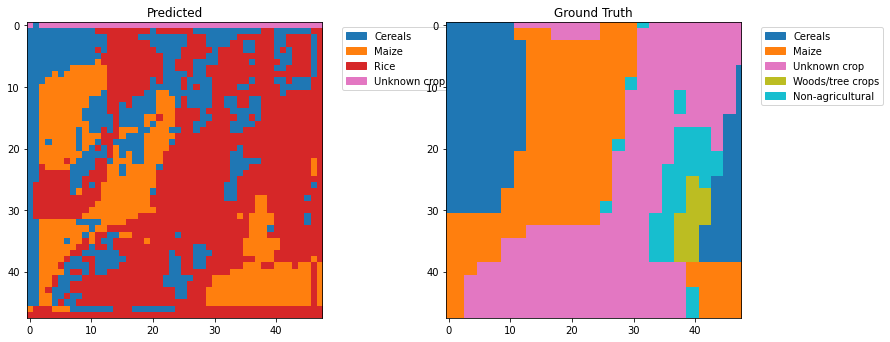

📊 Ground Truth Pixel Count Per Class:
  Cereals: 0
  Maize: 1010
  Rice: 7474
  Forage: 0
  Unknown crop: 2226
  Woods/tree crops: 7088
  Non-agricultural: 634

🤖 Predicted Pixel Count Per Class:
  Cereals: 8167
  Maize: 8366
  Rice: 1533
  Forage: 0
  Unknown crop: 366
  Woods/tree crops: 0
  Non-agricultural: 0

✅ Per-pixel Accuracy: 0.0413


In [18]:
def visualize(model, dataset, idx=0, num_classes=7, label_names=None):
    import matplotlib.patches as mpatches

    model.eval()
    X, y = dataset[idx]
    X = X.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(X).argmax(1).squeeze().cpu().numpy()
    
    y = y.numpy()

    pred_classes = np.unique(pred)
    gt_classes = np.unique(y)

    # Create color map and legends with names
    cmap = plt.cm.get_cmap('tab10', num_classes)
    pred_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in pred_classes]
    gt_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in gt_classes]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title("Predicted")
    plt.legend(handles=pred_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    plt.imshow(y, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title("Ground Truth")
    plt.legend(handles=gt_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


def evaluate_full_dataset(model, data_loader, num_classes=7, label_names=None):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=int)
    gt_counts = np.zeros(num_classes, dtype=int)
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(1)

            preds_np = preds.cpu().numpy().flatten()
            y_np = y.cpu().numpy().flatten()

            for cls in range(num_classes):
                pred_counts[cls] += np.sum(preds_np == cls)
                gt_counts[cls] += np.sum(y_np == cls)

            correct += np.sum(preds_np == y_np)
            total += y_np.size

    print("📊 Ground Truth Pixel Count Per Class:")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {gt_counts[cls]}")

    print("\n🤖 Predicted Pixel Count Per Class:")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {pred_counts[cls]}")

    print(f"\n✅ Per-pixel Accuracy: {correct / total:.4f}")


label_names = {
    0: "Cereals",
    1: "Maize",
    2: "Rice",
    3: "Forage",
    4: "Unknown crop",
    5: "Woods/tree crops",
    6: "Non-agricultural"
}

visualize(model, train_dataset, idx=2, num_classes=7, label_names=label_names)
evaluate_full_dataset(model, train_loader, num_classes=7, label_names=label_names)


# Loading Model

In [ ]:
epoch = 10
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.to(device)
